In [1]:
import networkx as nx
import pickle

import numpy as np; np.set_printoptions(suppress=True, linewidth=180); np.seterr(divide='ignore')
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from plot_module import plot_ode_results, plot_sde_results, plot_simulator_graph, plot_neuron_graph_subset, plot_twocomponent_results, plot_onecomponent_results
from sim_param_from_network import names_from_network, sde_param_from_network, ode_from_network, start_state_from_nodes
from neuron_graph_process import neuron_graph_process
from neuron_graph_helper import load_pickled_neuron_graph
from analyse_simulation import two_component_statistics, one_component_statistics

from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping

In [2]:
model = 'model_1node'

In [3]:
G = load_pickled_neuron_graph(f'neuron_graphs/{model}.pkl')

In [4]:
DELTA = 0.5
NSS = 21
K = 0.4

DEATH_IN_AXON = False

for node, data in G.nodes(data = True):
    if data['nodetype'] == 1:
        data['delta'] = DELTA
        data['birth_rate'] = K
        data['death_rate'] = K
    data['nss'] = NSS
    
    
    if data['nodetype'] == 2:
        if DEATH_IN_AXON:
            data['death_rate'] = K
        else:
            data['death_rate'] = 0
            
for x, y, data in G.edges(data = True):            
    if data['direction'] == 'forward':
        if DEATH_IN_AXON:
            data['rate'] = 2*K
        else:
            data['rate'] = K
    elif data['direction'] == 'reverse':
        if DEATH_IN_AXON:
            data['rate'] = K
        else:
            data['rate'] = K
        

#ode_model = ode_from_network(G, prnt=True)
        
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.5, delta=DELTA)
print(START_STATE)
print(START_STATE[0]+DELTA*START_STATE[1])

# get the parameter values for which the simulations will be run
C_B_val = sequence = [round(i * 10**-decimals, 14) for decimals in range(2, 8) for i in range(10, 0, -1)]
C_B_val = [element for i, element in enumerate(C_B_val) if i % 2 == 0] # sparseify for testing
print(f"preparing to simulate {model} with the following parameters:")
print(C_B_val, '\n')

[14, 14]
21.0
preparing to simulate model_1node with the following parameters:
[0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0.0008, 0.0006, 0.0004, 0.0002, 0.0001, 8e-05, 6e-05, 4e-05, 2e-05, 1e-05, 8e-06, 6e-06, 4e-06, 2e-06, 1e-06, 8e-07, 6e-07, 4e-07, 2e-07] 




<<<< STARTING SIMULATION WITH C_B = 0.013 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:23<00:00, 4328.29it/s]


         t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  wt_mean  wt_sem  mt_mean  mt_sem
0      0.0    28.00    0.00     21.00     0.00    0.5000   0.0000   0.0000   0.0000  0.0000    14.00    0.00    14.00    0.00
50    60.0    28.95    0.04     19.46     0.02    0.5060   0.0015   0.3850   0.4012  0.0112     9.98    0.03    18.97    0.06
100  120.0    29.09    0.04     19.10     0.02    0.5149   0.0016   0.4833   0.4581  0.0299     9.11    0.03    19.97    0.07
150  180.0    28.76    0.04     18.72     0.02    0.5253   0.0016   0.4971   0.4497  0.0493     8.68    0.03    20.09    0.07
200  240.0    28.45    0.05     18.38     0.02    0.5359   0.0016   0.4989   0.4321  0.0685     8.31    0.03    20.14    0.07
250  300.0    28.11    0.05     18.04     0.02    0.5464   0.0016   0.4990   0.4143  0.0867     7.97    0.03    20.13    0.07
300  360.0    27.76    0.05     17.69     0.02    0.5572   0.0017   0.4990   0.3965  0.1045     7.61    0.03    20.15 

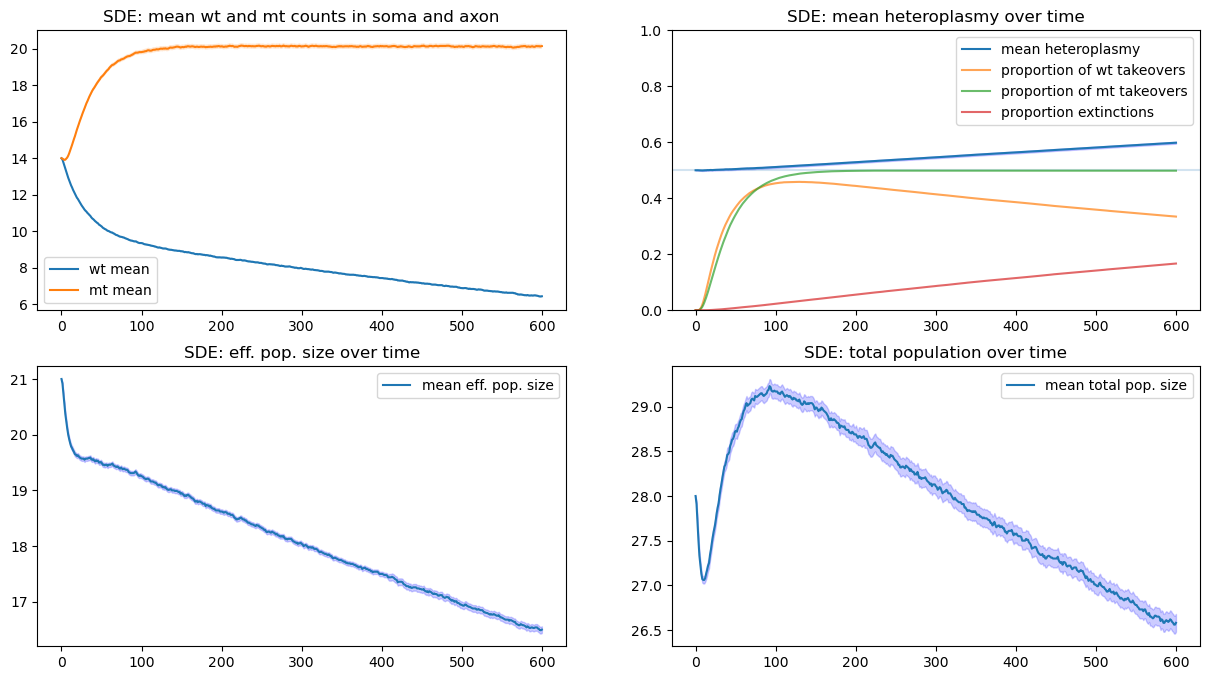


 ----- 



In [5]:
T = 600
TIME_POINTS = np.linspace(0, T, 501)
REP = 100000

C_B_val = [0.013]

for c_b in C_B_val:
    print(f"\n<<<< STARTING SIMULATION WITH C_B = {c_b} >>>>\n")
    
    for node, data in G.nodes(data = True):
        if data['nodetype'] == 1:
            data['c_b'] = c_b
        
            
#     # infer the ode model
#     ode_model = ode_from_network(G, prnt=True)

#     # run the ode model
#     ode_results = simulate_ode(ode_model, TIME_POINTS, START_STATE)
#     plot_ode_results(ode_results, TIME_POINTS, DELTA, VARS, NODES, prnt=False)

    # infer the parameterse of the sde systems
    SDE_PARAM = sde_param_from_network(G, prnt=False)

    # run the gillespie simulation
    gillespie_results = simulate_gillespie(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP)

    df_g = one_component_statistics(gillespie_results, TIME_POINTS, DELTA)
    
    print(df_g.iloc[[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, -1]]);print()
    plot_onecomponent_results(df_g)

#     df_g, df_2 = two_component_statistics(gillespie_results, TIME_POINTS, DELTA)
    
#     print(df_g.iloc[[0, -1]]);print()
#     plot_twocomponent_results(df_g)
    
    
#     # run the tau leaping simulation
#     tauleaping_results = simulate_tauleaping(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP, timestep=0.001)
#     df_t = one_component_statistics(tauleaping_results, TIME_POINTS, DELTA)
    
#     print(df_t.iloc[[0, -1]]);print()
#     plot_onecomponent_results(df_t)
    
    print("\n ----- \n")